In [ ]:
%pip install matplotlib numpy hpsv2 datasets

# Aesthetic Score

In [6]:
import matplotlib.pyplot as plt
import numpy as np

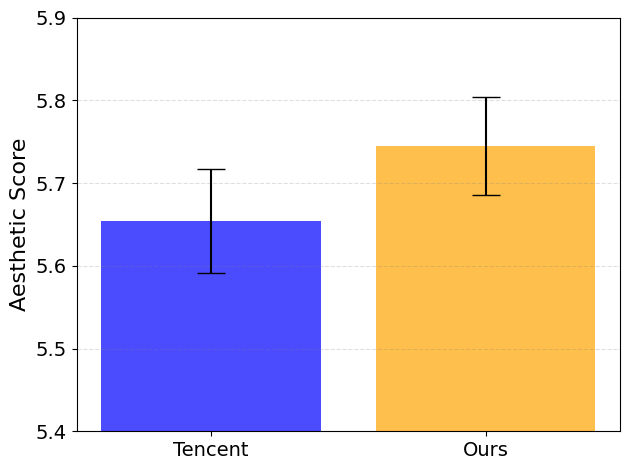

In [24]:
# Example data
aesthetic_scores = [5.654, 5.745]
aesthetic_scores_std = [0.321, 0.303]
n = 100  # Sample size

# Calculate standard error
std_errors = [std / np.sqrt(n) for std in aesthetic_scores_std]

# Calculate the 95% confidence intervals
confidence_intervals = [1.96 * se for se in std_errors]

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(["Tencent", "Ours"], aesthetic_scores, yerr=confidence_intervals, capsize=10, color=['blue', 'orange'], alpha=0.7)

# Add labels and title
ax.set_ylabel('Aesthetic Score', fontsize=16)
ax.set_xticklabels(["Tencent", "Ours"], fontsize=14)
# increase the size of the y-axis ticks
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim((5.4, 5.9))

# Add grid lines as dashed lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Show the plot
plt.tight_layout()
plt.savefig('adapter_aesthetic_scores.pdf')
plt.show()

# HPS

In [12]:
import hpsv2
import datasets
from tqdm.auto import trange

dataset = datasets.load_dataset("clement-bonnet/coco_val2017_100_text_image_pose", split="test")

/Users/clement/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
tencent_hpsv_scores = []
for i in trange(100):
    caption = dataset[i]["caption"]
    image_path = f"adapter_generations/tencent_{i}_scale_1_factor_1_refiner_03.png"
    tencent_hpsv_scores.append(hpsv2.score(image_path, caption, hps_version="v2.1")[0])
tencent_hpsv_scores = np.array(tencent_hpsv_scores)

100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


In [25]:
clem_hpsv_scores = []
for i in trange(100):
    caption = dataset[i]["caption"]
    image_path = f"adapter_generations/clem_{i}_scale_1_factor_1_refiner_03.png"
    clem_hpsv_scores.append(hpsv2.score(image_path, caption, hps_version="v2.1")[0])
clem_hpsv_scores = np.array(clem_hpsv_scores)

100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


In [29]:
print([tencent_hpsv_scores.mean(), clem_hpsv_scores.mean()])
print([tencent_hpsv_scores.std(), clem_hpsv_scores.std()])

[0.2612768, 0.2768673]
[0.031829383, 0.033367824]


In [30]:
print("win ratio:", (clem_hpsv_scores > tencent_hpsv_scores).mean())

win ratio: 0.76


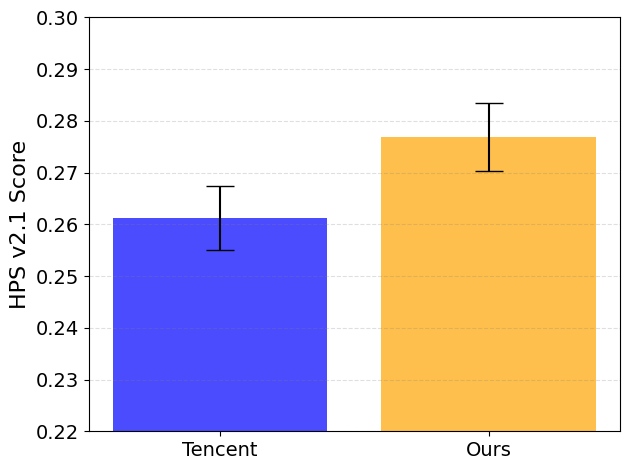

In [34]:
# Example data
hps_scores = [0.2612768, 0.2768673]
hps_scores_std = [0.031829383, 0.033367824]
n = 100  # Sample size

# Calculate standard error
std_errors = [std / np.sqrt(n) for std in hps_scores_std]

# Calculate the 95% confidence intervals
confidence_intervals = [1.96 * se for se in std_errors]

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(["Tencent", "Ours"], hps_scores, yerr=confidence_intervals, capsize=10, color=['blue', 'orange'], alpha=0.7)

# Add labels and title
ax.set_ylabel('HPS v2.1 Score', fontsize=16)
ax.set_xticklabels(["Tencent", "Ours"], fontsize=14)
# increase the size of the y-axis ticks
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim((0.22, 0.3))

# Add grid lines as dashed lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# Show the plot
plt.tight_layout()
plt.savefig('adapter_hps_scores.pdf')
plt.show()

# Human Ranking

In [1]:
import random

import ipywidgets as widgets
from IPython.display import display
from PIL import Image

from utils import draw_pose_on_image

/Users/clement/text-to-pose/.venv/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [6]:
# Assume these are your lists of images (using file paths for demonstration)
pose_imgs = [f"adapter_generations/pose_{i}.png" for i in range(100)]
tencent_imgs = [f"adapter_generations/tencent_{i}_scale_1_factor_1_refiner_03.png" for i in range(100)]
clem_imgs = [f"adapter_generations/clem_{i}_scale_1_factor_1_refiner_03.png" for i in range(100)]

# shuffle indices
indices = list(range(100))
random.shuffle(indices)

# Counters and storage for results
aesthetics_wins = {'tencent': 0, 'clem': 0}
pose_matching_wins = {'tencent': 0, 'clem': 0}
current_index = 0
swap = False

# Widgets
left_image = widgets.Image(width=512)
right_image = widgets.Image(width=512)
button_aesthetics_left = widgets.Button(description='Aesthetics: Left')
button_aesthetics_right = widgets.Button(description='Aesthetics: Right')
button_pose_matching_left = widgets.Button(description='Pose Matching: Left')
button_pose_matching_right = widgets.Button(description='Pose Matching: Right')
button_skip = widgets.Button(description='Skip')
output = widgets.Output()

def update_images():
    global current_index
    if current_index < len(tencent_imgs):
        idx = indices[current_index]
        pose_image = Image.open(pose_imgs[idx])
        draw_pose_on_image(pose_image, Image.open(tencent_imgs[idx]), 0.5).save("tmp/img.png")
        with open("tmp/img.png", "rb") as f:
            left_image.value = f.read()
        draw_pose_on_image(pose_image, Image.open(clem_imgs[idx]), 0.5).save("tmp/img.png")
        with open("tmp/img.png", "rb") as f:
            right_image.value = f.read()
    else:
        with output:
            print("Comparison completed!")
        display_results()

def update_images_swap():
    global current_index
    if current_index < len(tencent_imgs):
        idx = indices[current_index]
        pose_image = Image.open(pose_imgs[idx])
        draw_pose_on_image(pose_image, Image.open(tencent_imgs[idx]), 0.5).save("tmp/img.png")
        with open("tmp/img.png", "rb") as f:
            right_image.value = f.read()
        draw_pose_on_image(pose_image, Image.open(clem_imgs[idx]), 0.5).save("tmp/img.png")
        with open("tmp/img.png", "rb") as f:
            left_image.value = f.read()
    else:
        with output:
            print("Comparison completed!")
        display_results()

def on_aesthetics_left_clicked(b):
    global swap
    if not swap:
        aesthetics_wins['tencent'] += 1
    else:
        aesthetics_wins['clem'] += 1

def on_aesthetics_right_clicked(b):
    global swap
    if not swap:
        aesthetics_wins['clem'] += 1
    else:
        aesthetics_wins['tencent'] += 1

def on_pose_matching_left_clicked(b):
    global swap
    if not swap:
        pose_matching_wins['tencent'] += 1
    else:
        pose_matching_wins['clem'] += 1
    next_image()

def on_pose_matching_right_clicked(b):
    global swap
    if not swap:
        pose_matching_wins['clem'] += 1
    else:
        pose_matching_wins['tencent'] += 1
    next_image()

def next_image():
    global current_index
    global swap
    global aesthetics_wins
    global pose_matching_wins
    # Flush
    with output:
        output.clear_output()
        print(f"Comparison {current_index + 1}/{len(tencent_imgs)}")
        print(f"Aesthetics: Tencent - {aesthetics_wins['tencent']} | Clem - {aesthetics_wins['clem']}")
        print(f"Pose Matching: Tencent - {pose_matching_wins['tencent']} | Clem - {pose_matching_wins['clem']}")
    current_index += 1
    if current_index < len(clem_imgs):
        if random.random() < 0.5:
            update_images()
            swap = False
        else:
            update_images_swap()
            swap = True
    else:
        with output:
            print("Comparison completed!")
        display_results()

def display_results():
    total_comparisons = current_index
    if total_comparisons == 0:
        return
    aesthetics_win_rate_tencent = aesthetics_wins['tencent'] / total_comparisons
    aesthetics_win_rate_clem = aesthetics_wins['clem'] / total_comparisons
    realism_win_rate_tencent = pose_matching_wins['tencent'] / total_comparisons
    realism_win_rate_clem = pose_matching_wins['clem'] / total_comparisons

    with output:
        print(f"Aesthetics Win Rate - Tencent: {aesthetics_win_rate_tencent:.2f}")
        print(f"Aesthetics Win Rate - Clem: {aesthetics_win_rate_clem:.2f}")
        print(f"Pose Matching Win Rate - Tencent: {realism_win_rate_tencent:.2f}")
        print(f"Pose Matching Win Rate - Clem: {realism_win_rate_clem:.2f}")

# Link buttons to their respective functions
button_aesthetics_left.on_click(on_aesthetics_left_clicked)
button_aesthetics_right.on_click(on_aesthetics_right_clicked)
button_pose_matching_left.on_click(on_pose_matching_left_clicked)
button_pose_matching_right.on_click(on_pose_matching_right_clicked)
button_skip.on_click(lambda b: next_image())

# Display initial images and buttons
if random.random() < 0.5:
    update_images()
    swap = False
else:
    update_images_swap()
    swap = True
display(
    widgets.HBox([left_image, right_image]),
    widgets.HBox([button_aesthetics_left, button_aesthetics_right]),
    widgets.HBox([button_pose_matching_left, button_pose_matching_right, button_skip]),
    output
)


Output()

In [7]:
print("Aesthetic Clem wins:", aesthetics_wins['clem'])
print("Aesthetic Tencent wins:", aesthetics_wins['tencent'])
print("Aesthetic draws:", 100 - aesthetics_wins['clem'] - aesthetics_wins['tencent'])
print("Pose Clem wins:", pose_matching_wins['clem'])
print("Pose Tencent wins:", pose_matching_wins['tencent'])
print("Pose draws:", 100 - pose_matching_wins['clem'] - pose_matching_wins['tencent'])

Aesthetic Clem wins: 77
Aesthetic Tencent wins: 22
Aesthetic draws: 1
Pose Clem wins: 77
Pose Tencent wins: 5
Pose draws: 18


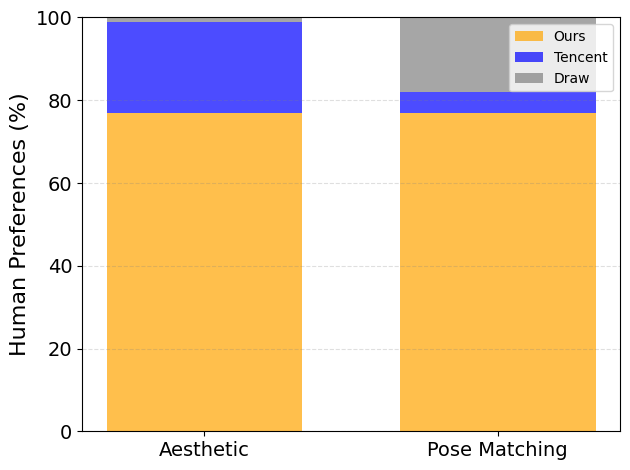

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for two cumulative bars
categories = ["Ours", "Tencent", "Draw"]
scores1 = [77, 22, 1]
scores2 = [77, 5, 18]
colors = ['orange', 'blue', 'grey']

# Width of the bars
bar_width = 0.35

# X-coordinates for the bars
index = np.arange(2)

# Create the bar plot
fig, ax = plt.subplots()

# Create the first stacked bar
ax.bar(bar_width/2, scores1[0], width=bar_width, color=colors[0], alpha=0.7, label=categories[0])
for i in range(1, len(scores1)):
    ax.bar(bar_width/2, scores1[i], width=bar_width, bottom=np.sum(scores1[:i]), color=colors[i], alpha=0.7, label=categories[i])

# Create the second stacked bar
ax.bar(1.5*bar_width + bar_width/2, scores2[0], width=bar_width, alpha=0.7, color=colors[0])
for i in range(1, len(scores2)):
    ax.bar(1.5*bar_width + bar_width/2, scores2[i], width=bar_width, bottom=np.sum(scores2[:i]), alpha=0.7, color=colors[i])

# Add labels and title
ax.set_ylabel('Human Preferences (%)', fontsize=16)
ax.set_xticks([bar_width/2, 1.5*bar_width + bar_width/2])
ax.set_xticklabels(["Aesthetic", "Pose Matching"], fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim((0, 100))

# Add grid lines as dashed lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

# # Add legend
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys())
ax.legend()
# Show the plot
plt.tight_layout()
plt.savefig('human_preferences.pdf')
plt.show()

# Adapter Generations

In [48]:
from PIL import Image
import matplotlib.pyplot as plt
import datasets

dataset = datasets.load_dataset("clement-bonnet/coco_val2017_100_text_image_pose", split="test")

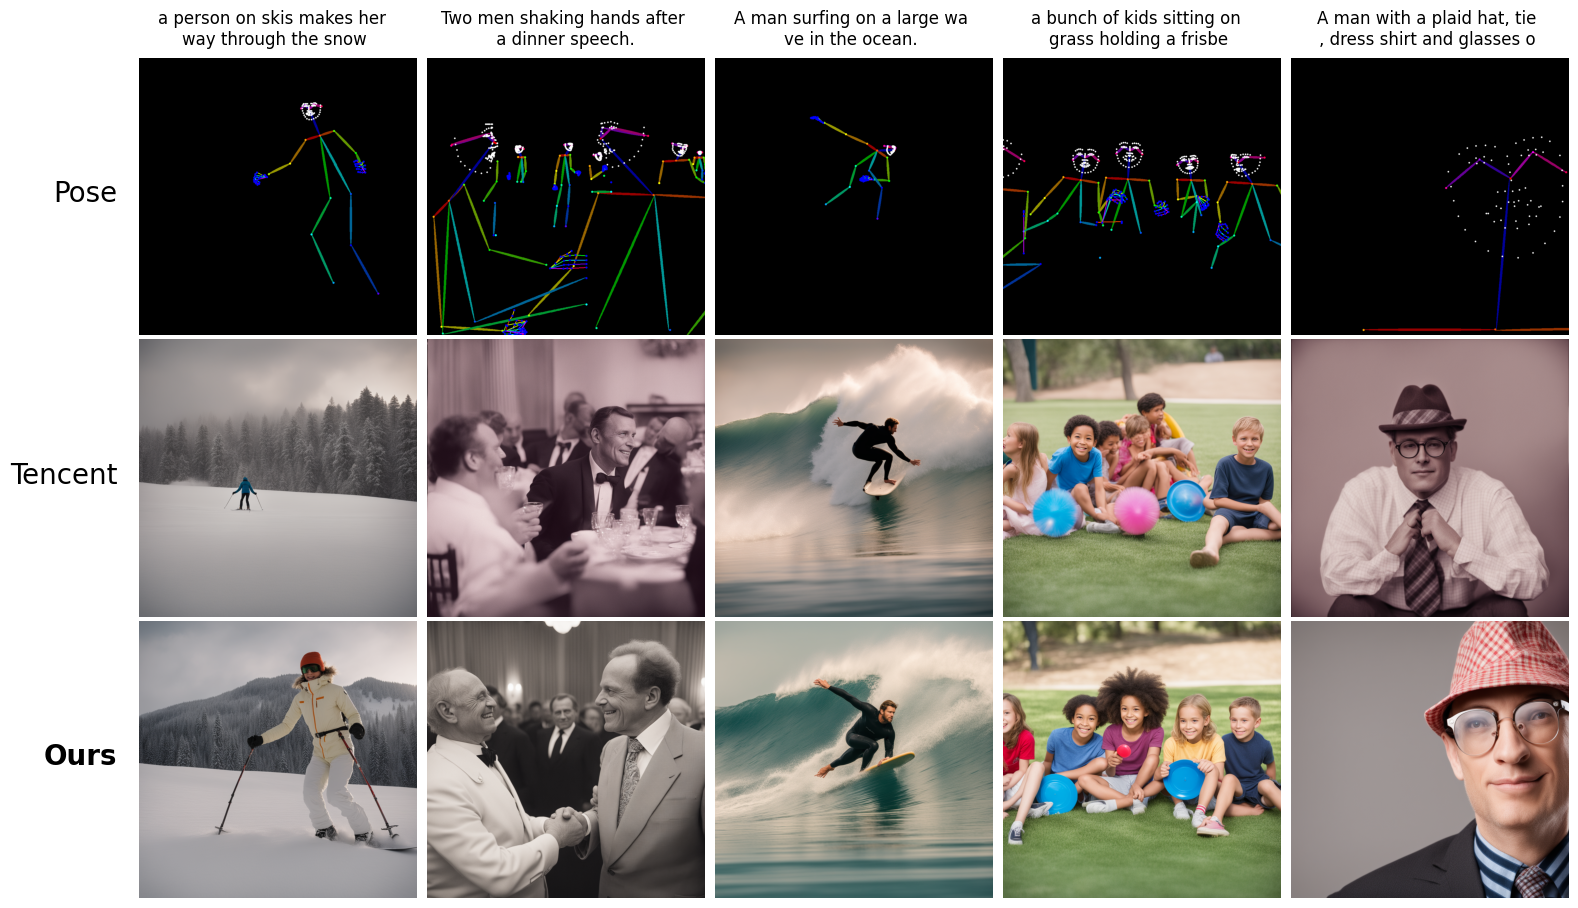

In [128]:
# Select pictures to display
# image_indices = [0, 5, 12, 13, 17]
image_indices = [0, 12, 13, 17, 23]
poses = [Image.open(f"adapter_generations/pose_{i}.png") for i in image_indices]
tencent_images = [Image.open(f"adapter_generations/tencent_{i}_scale_1_factor_1_refiner_03.png") for i in image_indices]
clem_images = [Image.open(f"adapter_generations/clem_{i}_scale_1_factor_1_refiner_03.png") for i in image_indices]
captions = [dataset[i]["caption"] for i in image_indices]

# Number of poses and models
num_poses = len(poses)

# Create a figure with subplots including an additional row for headers
fig, axes = plt.subplots(3, num_poses, figsize=(15.0, 8.5))  # Adjust figsize to fit your screen, added one more row

# Set titles for the first row (headers)
row_titles = ['Pose', 'Tencent', 'Ours']
for ax, row_title in zip(axes[:, 0], row_titles):
    if row_title == 'Ours':
        ax.text(-80, 500, row_title, fontsize=20, fontweight='bold', ha='right', va='center')
    else:
        ax.text(-80, 500, row_title, fontsize=20, ha='right', va='center')
    ax.axis('off')  # Hide the axes

for ax, caption in zip(axes[0], ["\n".join([c[27*i:27*(i+1)] for i in range(len(c)//27 + 1)][:2]) for c in captions]):
    ax.text(500, -180, caption, fontsize=12, ha='center', va='top')
    ax.axis('off')  # Hide the axes

# Displaying each set of images
for i in range(num_poses):
    # Display poses in the first row (actual image rows start from the second row now)
    axes[0, i].imshow(poses[i])
    axes[0, i].axis('off')  # Turn off axis

    # Display images from model 1 in the second row
    axes[1, i].imshow(tencent_images[i])
    axes[1, i].axis('off')  # Turn off axis

    # Display images from model 2 in the third row
    axes[2, i].imshow(clem_images[i])
    axes[2, i].axis('off')  # Turn off axis

# Adjust spacing
plt.tight_layout(pad=-2.0)
plt.savefig('adapter_generations.pdf', bbox_inches='tight')
plt.show()